In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dense, Layer, Dropout, Flatten, SimpleRNN, Reshape
import tensorflow as tf
from keras.regularizers import l2
from keras.optimizers import Adam
from tensorflow.keras.optimizers import legacy
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from statsmodels.tsa.stattools import adfuller

In [2]:
# Load the dataset
data = pd.read_csv("/content/ADANIPORTS.csv")

# Data Analysis

In [ ]:
#first five records of the data
data.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2007-11-27,MUNDRAPORT,EQ,440.00,770.00,1050.00,770.0,959.0,962.90,984.72,27294366,2.687719e+15,NaN,9859619,0.3612
1,2007-11-28,MUNDRAPORT,EQ,962.90,984.00,990.00,874.0,885.0,893.90,941.38,4581338,4.312765e+14,NaN,1453278,0.3172
2,2007-11-29,MUNDRAPORT,EQ,893.90,909.00,914.75,841.0,887.0,884.20,888.09,5124121,4.550658e+14,NaN,1069678,0.2088
3,2007-11-30,MUNDRAPORT,EQ,884.20,890.00,958.00,890.0,929.0,921.55,929.17,4609762,4.283257e+14,NaN,1260913,0.2735
4,2007-12-03,MUNDRAPORT,EQ,921.55,939.75,995.00,922.0,980.0,969.30,965.65,2977470,2.875200e+14,NaN,816123,0.2741


In [ ]:
data.shape

(2993, 15)

In [ ]:
data.columns

Index(['Date', 'Symbol', 'Series', 'Prev Close', 'Open', 'High', 'Low', 'Last',
       'Close', 'VWAP', 'Volume', 'Turnover', 'Trades', 'Deliverable Volume',
       '%Deliverble'],
      dtype='object')

In [ ]:
#should convert 'Date' from object to datetime
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2993 entries, 0 to 2992
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                2993 non-null   object 
 1   Symbol              2993 non-null   object 
 2   Series              2993 non-null   object 
 3   Prev Close          2993 non-null   float64
 4   Open                2993 non-null   float64
 5   High                2993 non-null   float64
 6   Low                 2993 non-null   float64
 7   Last                2993 non-null   float64
 8   Close               2993 non-null   float64
 9   VWAP                2993 non-null   float64
 10  Volume              2993 non-null   int64  
 11  Turnover            2993 non-null   float64
 12  Trades              2126 non-null   float64
 13  Deliverable Volume  2993 non-null   int64  
 14  %Deliverble         2993 non-null   float64
dtypes: float64(10), int64(2), object(3)
memory usage: 350.9

In [ ]:
#we have 867 null value in traders
data.isnull().sum()

Date                    0
Symbol                  0
Series                  0
Prev Close              0
Open                    0
High                    0
Low                     0
Last                    0
Close                   0
VWAP                    0
Volume                  0
Turnover                0
Trades                867
Deliverable Volume      0
%Deliverble             0
dtype: int64

In [ ]:
duplicates=data.duplicated().sum()
print("number of duplicates: ",duplicates)

number of duplicates:  3


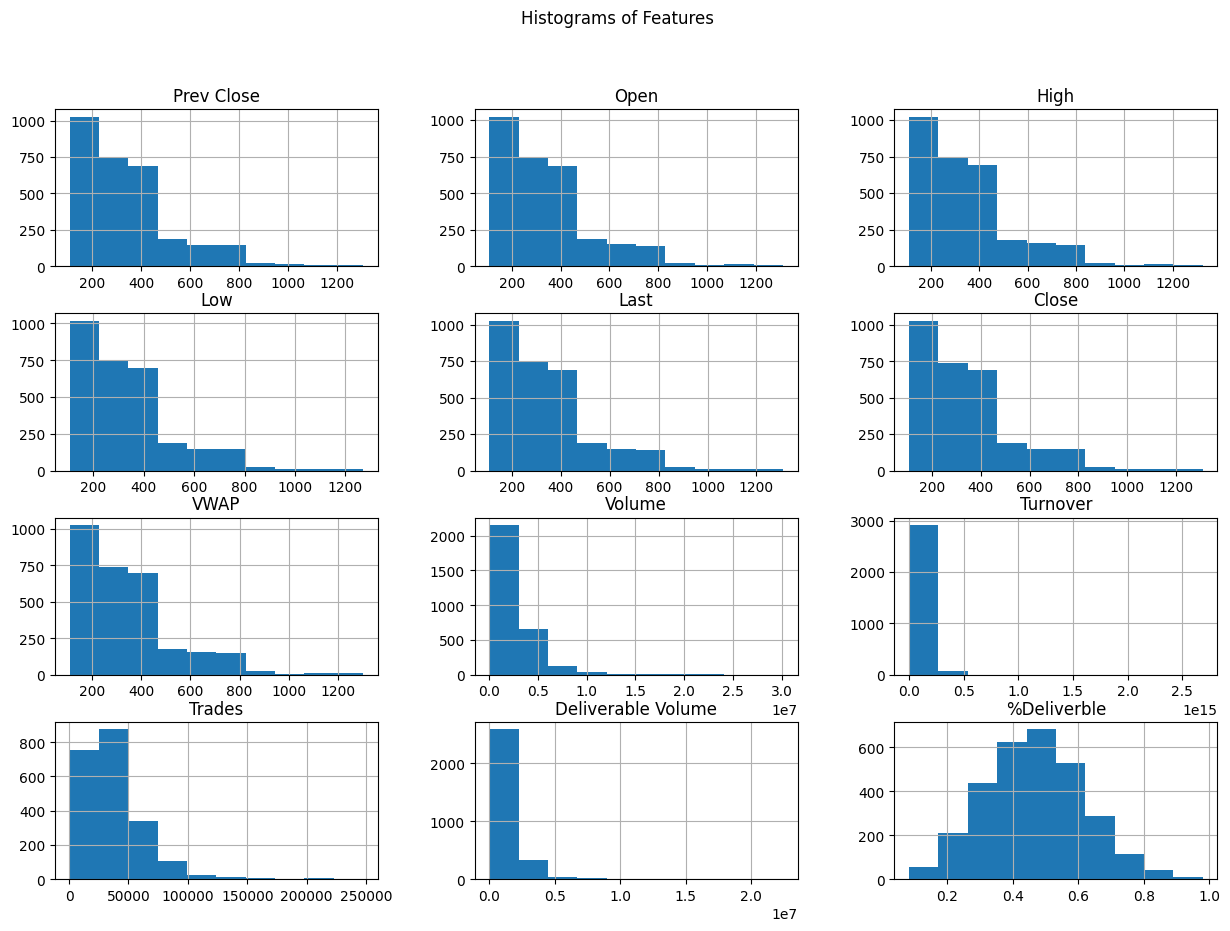

In [ ]:
data.hist(figsize=(15, 10))
plt.suptitle('Histograms of Features')
plt.show()

**Price-Related Columns (Prev Close, Open, High, Low, Last, Close, VWAP):**
- The right skewness in these columns indicates that lower prices are more common, with occasional higher prices.
- Most trading activity tends to occur at lower price levels, with relatively few occurrences of higher prices.
- There might be occasional spikes in price, but they are less frequent compared to lower price levels

**Trading-Related Metrics (Volume, Turnover, Trades, Deliverable Volume):**
- The right skewness suggests that lower values (e.g., lower trading volume, turnover, or number of trades) are more common, with relatively few occurrences of higher values.
- Most trading activity tends to be lower in magnitude, with occasional spikes in activity during certain periods.
- There may be outliers representing days of unusually high trading activity, but they are less frequent compared to days with lower trading activity.

**'%Deliverble' column follows a symmetric or approximately normal distribution:**
- A symmetric or normal distribution in the '%Deliverble' column suggests that the proportion of deliverable quantity to total traded quantity is evenly spread around its mean value.
- There is no bias towards higher or lower percentages of deliverable quantity relative to total traded quantity.
- The distribution indicates that similar proportions of shares are being delivered in trading transactions, with no significant skewness towards either end of the distribution.

In [ ]:
#now 'Date' is datetime
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2993 entries, 0 to 2992
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                2993 non-null   datetime64[ns]
 1   Symbol              2993 non-null   object        
 2   Series              2993 non-null   object        
 3   Prev Close          2993 non-null   float64       
 4   Open                2993 non-null   float64       
 5   High                2993 non-null   float64       
 6   Low                 2993 non-null   float64       
 7   Last                2993 non-null   float64       
 8   Close               2993 non-null   float64       
 9   VWAP                2993 non-null   float64       
 10  Volume              2993 non-null   int64         
 11  Turnover            2993 non-null   float64       
 12  Trades              2126 non-null   float64       
 13  Deliverable Volume  2993 non-null   int64       

In [ ]:
#descriptive Statistics view for the data
data.describe()

,Date,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
count,2993,2993.000000,2993.000000,2993.000000,2993.000000,2993.000000,2993.000000,2993.000000,2.993000e+03,2.993000e+03,2126.000000,2.993000e+03,2993.000000
mean,2013-12-11 05:06:57.373872384,335.464384,336.065987,342.786853,328.961894,335.487337,335.441898,336.143976,2.415617e+06,7.328238e+13,37579.424741,1.149000e+06,0.465744
min,2007-11-27 00:00:00,108.000000,108.000000,110.450000,105.650000,108.000000,108.000000,108.340000,1.236600e+04,2.415857e+11,366.000000,5.383000e+03,0.083400
25%,2010-12-09 00:00:00,156.500000,156.500000,159.750000,153.600000,157.000000,156.500000,156.570000,6.539770e+05,1.634138e+13,19149.250000,2.810780e+05,0.360500
50%,2013-12-04 00:00:00,314.150000,315.000000,319.950000,308.700000,314.000000,314.150000,314.970000,1.780060e+06,4.928907e+13,33258.000000,7.453050e+05,0.464600
75%,2016-12-19 00:00:00,398.750000,399.000000,405.300000,391.550000,398.150000,398.700000,399.240000,3.245961e+06,1.015801e+14,48716.000000,1.536874e+06,0.566700
max,2019-12-31 00:00:00,1307.450000,1310.250000,1324.000000,1270.000000,1308.000000,1307.450000,1302.150000,3.011128e+07,2.687719e+15,247483.000000,2.241652e+07,0.979800
std,NaN,195.714240,196.349373,201.456890,191.296805,195.883211,195.703575,196.571658,2.644873e+06,9.703476e+13,26153.821111,1.370194e+06,0.151321


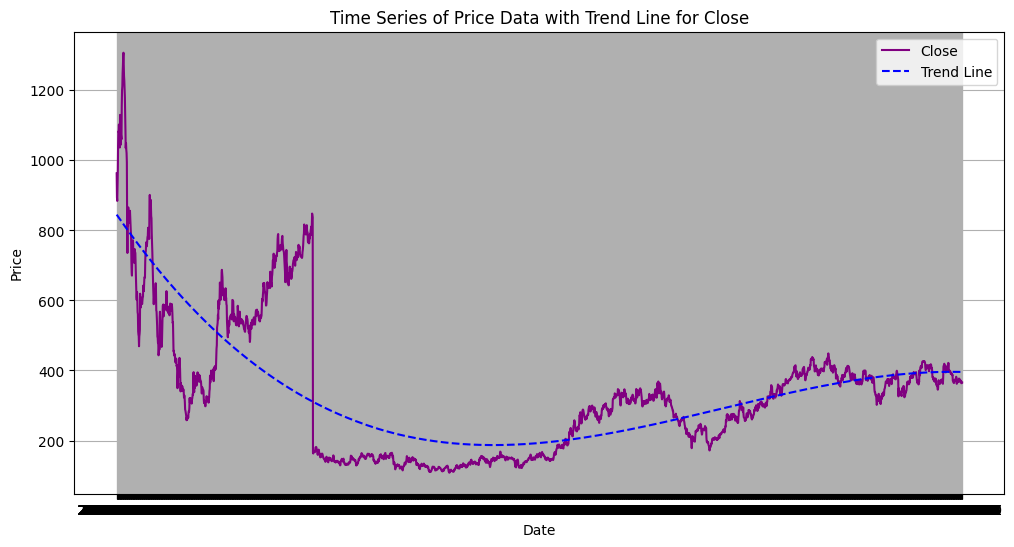

In [4]:
# Set the figure size
plt.figure(figsize=(12, 6))

# Plot the 'Close' prices
plt.plot(data['Date'], data['Close'], color='purple', label='Close')

# Fit a polynomial trend line
degree = 3  # You can adjust the degree of the polynomial as needed
poly_coeffs = np.polyfit(range(len(data['Close'])), data['Close'], degree)
trend_line = np.poly1d(poly_coeffs)
plt.plot(data['Date'], trend_line(range(len(data['Close']))), color='blue', linestyle='--', label='Trend Line')

# Add a legend
plt.legend()

# Add titles and labels
plt.title('Time Series of Price Data with Trend Line for Close')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)

# Show the plot
plt.show()

- All price-related columns have identical values
- There is no variability in the prices (Open, High, Low, Last, Close) across different time periods
- This could indicate potential data quality issues or a lack of price movement during the observed time frame

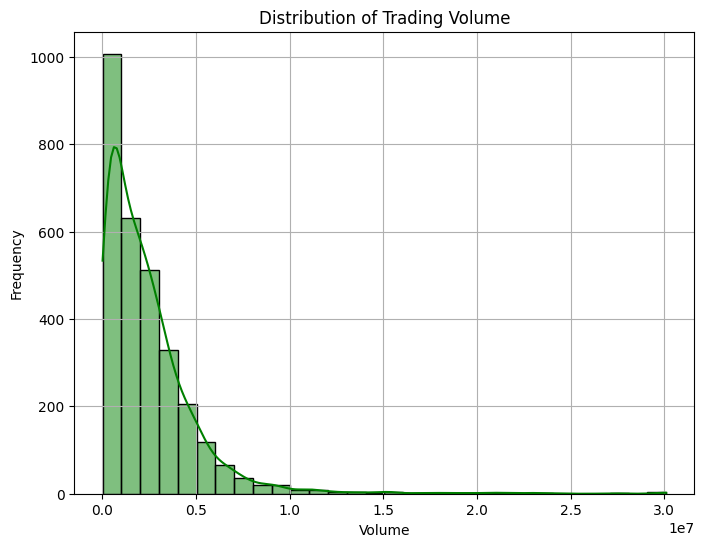

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(data['Volume'], bins=30, kde=True, color='green')
plt.title('Distribution of Trading Volume')
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Trading volume simply refers to the total number of shares (or contracts) of a stock or other financial asset that have been bought and sold during a specific time period, like a day or a week. It's like counting how many times a stock has changed hands between buyers and sellers.

skewness to the right in trading volume means that most of the trading activity involves lower volumes of shares being traded, while there are occasional instances of higher trading volumes. It suggests that smaller transactions are more common

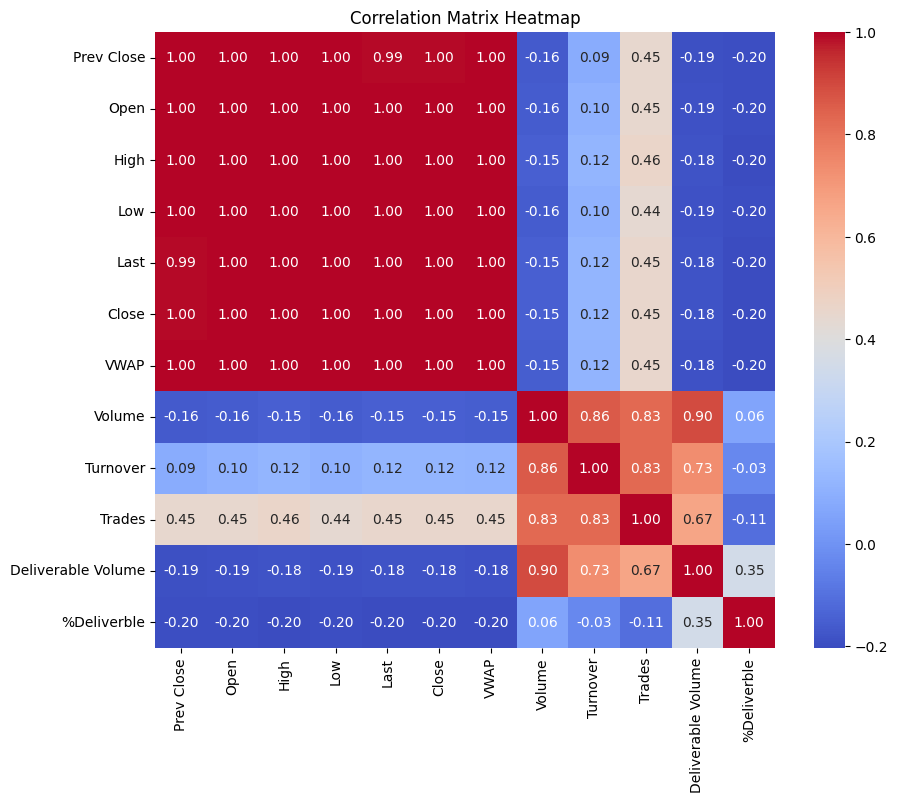

In [ ]:
numeric_columns = data.select_dtypes(include=['number'])
correlation_matrix = numeric_columns.corr()

plt.figure(figsize=(10, 8))
plt.title('Correlation Matrix Heatmap')
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()


- There are strong positive correlations (> 0.95) between 'Prev Close', 'Open', 'High', 'Low', 'Last', and 'Close',
- indicating that these variables are highly correlated, which is expected as they are related to stock price movements.
- The correlation between 'Volume' and 'Deliverable Volume' is relatively high (0.90), indicating a strong positive relationship,
- suggesting that higher trading volumes are associated with higher deliverable volumes of shares.
- The correlation between 'Volume' and '%Deliverble' is weak (0.06), suggesting little linear relationship between them.

In [ ]:
# Perform ADF test
result = adfuller(data['Close'].dropna())  # Drop NaN values before performing the test

# Extract and print test results
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

# Interpret the results
if result[1] <= 0.05:
    print("Reject the null hypothesis (H0): Data is stationary")
else:
    print("Fail to reject the null hypothesis (H0): Data is non-stationary")

ADF Statistic: -3.533429453338774
p-value: 0.007168932363670432
Critical Values:
   1%: -3.432542607157588
   5%: -2.8625087513967085
   10%: -2.5672856921402096
Reject the null hypothesis (H0): Data is stationary


**Seasonality: patterns in data that occur at regular intervals**

By removing seasonality, the data becomes more stationary, making it easier for models to identify and learn from the underlying patterns.

# Data Preprocessing

In [ ]:
#converting column 'Date' type to datetime to deal with the data as a time series
data['Date'] = pd.to_datetime(data['Date'])

In [ ]:
# Drop duplicates
data = data.drop_duplicates()
print("now number of duplicates is:", data.duplicated().sum())

now number of duplicates is: 0


In [ ]:
#number of records are 2990, and I have 867 null value in 'traders' so I will drop traders column
data.drop(columns=['Trades'], inplace=True)

In [ ]:
print('number of null values: ',data.isnull().sum().sum())

number of null values:  0


In [ ]:
# Select the desired columns
selected_columns = ['Date', 'Prev Close', 'Open', 'High', 'Low', 'Last', 'Close', 'VWAP', 'Volume', 'Turnover', 'Deliverable Volume', '%Deliverble']
selected_data = data[selected_columns]

# Display the selected data
print(selected_data.head())

        Date  Prev Close    Open     High    Low   Last   Close    VWAP  \
0 2007-11-27      440.00  770.00  1050.00  770.0  959.0  962.90  984.72   
1 2007-11-28      962.90  984.00   990.00  874.0  885.0  893.90  941.38   
2 2007-11-29      893.90  909.00   914.75  841.0  887.0  884.20  888.09   
3 2007-11-30      884.20  890.00   958.00  890.0  929.0  921.55  929.17   
4 2007-12-03      921.55  939.75   995.00  922.0  980.0  969.30  965.65   

     Volume      Turnover  Deliverable Volume  %Deliverble  
0  27294366  2.687719e+15             9859619       0.3612  
1   4581338  4.312765e+14             1453278       0.3172  
2   5124121  4.550658e+14             1069678       0.2088  
3   4609762  4.283257e+14             1260913       0.2735  
4   2977470  2.875200e+14              816123       0.2741  


In [ ]:
scaler = MinMaxScaler()
data['Close'] = scaler.fit_transform(data[['Close']])

In [ ]:
# Function to prepare data for time series prediction
def prepare_data(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data.iloc[i : i + n_steps].values)
        y.append(data.iloc[i + n_steps])
    return np.array(X), np.array(y)

# Set the number of time steps
n_steps = 10
X, y = prepare_data(data['Close'], n_steps)


# Reshape the data to make it 3D
X = X.reshape((X.shape[0], X.shape[1], 1))


### Splitting the time series data to (training, testing, and validation)

In [ ]:
# Split the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
# Print the shapes of the resulting datasets
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

X_train shape: (2384, 10, 1)
X_val shape: (298, 10, 1)
X_test shape: (298, 10, 1)
y_train shape: (2384,)
y_val shape: (298,)
y_test shape: (298,)


# Model Training and Evaluation

In [ ]:
# Adjust early stopping
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

In [ ]:
# Define the custom ESN layer
class EchoStateReservoir(Layer):
    def __init__(self, reservoir_size, spectral_radius=0.9, **kwargs):
        super(EchoStateReservoir, self).__init__(**kwargs)
        self.reservoir_size = reservoir_size
        self.spectral_radius = spectral_radius

    def build(self, input_shape):
        self.W_res = self.add_weight(
            shape=(self.reservoir_size, self.reservoir_size),
            initializer='random_normal',
            trainable=False
        )
        self.W_in = self.add_weight(
            shape=(input_shape[-1], self.reservoir_size),
            initializer='random_normal',
            trainable=False
        )
        self._initialize_weights()

    def _initialize_weights(self):
        W_res = np.random.rand(self.reservoir_size, self.reservoir_size) - 0.5
        W_res *= self.spectral_radius / np.max(np.abs(np.linalg.eigvals(W_res)))
        self.W_res.assign(W_res)
        W_in = np.random.rand(self.W_in.shape[0], self.W_in.shape[1]) - 0.5
        self.W_in.assign(W_in)

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        time_steps = tf.shape(inputs)[1]

        # Initialize reservoir states
        reservoir_states = tf.TensorArray(tf.float32, size=time_steps)
        state = tf.zeros((batch_size, self.reservoir_size))

        # Run the reservoir
        for t in tf.range(time_steps):
            input_t = inputs[:, t, :]
            state = tf.nn.tanh(tf.matmul(input_t, self.W_in) + tf.matmul(state, self.W_res))
            reservoir_states = reservoir_states.write(t, state)

        # Stack the reservoir states
        reservoir_states = tf.transpose(reservoir_states.stack(), perm=[1, 0, 2])
        return reservoir_states

In [ ]:
# Create the ESN model
model_esn = Sequential([
    EchoStateReservoir(reservoir_size=50, input_shape=(None, X_train.shape[2])),
    Dense(1)
])


# LSTM
model_lstm = Sequential([
    LSTM(50, activation='sigmoid', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

# Bi-LSTM
model_bilstm = Sequential([
    Bidirectional(LSTM(50, activation='sigmoid', input_shape=(X_train.shape[1], X_train.shape[2]))),
    Dense(1)
])


In [ ]:
# Compile models
model_esn.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_bilstm.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Train models
history_esn = model_esn.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val), callbacks=[es, lr_scheduler], verbose=2)
history_lstm = model_lstm.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val), callbacks=[es, lr_scheduler], verbose=2)
history_bilstm = model_bilstm.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val), callbacks=[es, lr_scheduler], verbose=2)

Epoch 1/50
38/38 - 1s - loss: 0.0408 - val_loss: 0.0347 - lr: 0.0010 - 1s/epoch - 31ms/step
Epoch 2/50
38/38 - 0s - loss: 0.0351 - val_loss: 0.0315 - lr: 0.0010 - 150ms/epoch - 4ms/step
Epoch 3/50
38/38 - 0s - loss: 0.0319 - val_loss: 0.0289 - lr: 0.0010 - 137ms/epoch - 4ms/step
Epoch 4/50
38/38 - 0s - loss: 0.0299 - val_loss: 0.0271 - lr: 0.0010 - 154ms/epoch - 4ms/step
Epoch 5/50
38/38 - 0s - loss: 0.0284 - val_loss: 0.0258 - lr: 0.0010 - 142ms/epoch - 4ms/step
Epoch 6/50
38/38 - 0s - loss: 0.0272 - val_loss: 0.0251 - lr: 0.0010 - 136ms/epoch - 4ms/step
Epoch 7/50
38/38 - 0s - loss: 0.0266 - val_loss: 0.0246 - lr: 0.0010 - 138ms/epoch - 4ms/step
Epoch 8/50
38/38 - 0s - loss: 0.0264 - val_loss: 0.0244 - lr: 0.0010 - 138ms/epoch - 4ms/step
Epoch 9/50
38/38 - 0s - loss: 0.0262 - val_loss: 0.0242 - lr: 0.0010 - 153ms/epoch - 4ms/step
Epoch 10/50
38/38 - 0s - loss: 0.0260 - val_loss: 0.0241 - lr: 0.0010 - 134ms/epoch - 4ms/step
Epoch 11/50
38/38 - 0s - loss: 0.0260 - val_loss: 0.0240 - lr

In [ ]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse, y_pred

mse_esn, y_pred_esn = evaluate_model(model_esn, X_test, y_test)
mse_lstm, y_pred_lstm = evaluate_model(model_lstm, X_test, y_test)
mse_bilstm, y_pred_bilstm = evaluate_model(model_bilstm, X_test, y_test)


10/10 [==============================] - 1s 7ms/step


In [ ]:
# Inverse transform predictions
y_pred_inv_esn = scaler.inverse_transform(y_pred_esn)
y_pred_inv_lstm = scaler.inverse_transform(y_pred_lstm)
y_pred_inv_bilstm = scaler.inverse_transform(y_pred_bilstm)

In [ ]:
# Print or use the mse values as needed
print(f'MSE ESN: {mse_esn}')
print(f'MSE LSTM: {mse_lstm}')
print(f'MSE BiLSTM: {mse_bilstm}')

MSE ESN: 0.00011170657707593084
MSE LSTM: 0.00014090010780249714
MSE BiLSTM: 0.0002904463973708131


In [ ]:
# Inverse transform predictions
y_pred_inv_esn = scaler.inverse_transform(y_pred_esn)
y_pred_inv_lstm = scaler.inverse_transform(y_pred_lstm)
y_pred_inv_bilstm = scaler.inverse_transform(y_pred_bilstm)

**will convert the predicted values to their original scale**

In [ ]:
# Replace [...] with the actual lists of predictions for each model
predictions_esn = [y_pred_esn]
predictions_lstm = [y_pred_lstm]
predictions_bilstm = [y_pred_bilstm]

# Calculate the standard deviation for each model
std_esn = np.std(predictions_esn)
std_lstm = np.std(predictions_lstm)
std_bilstm = np.std(predictions_bilstm)

# Print the standard deviation for each model
print("ESN Standard Deviation:", std_esn)
print("LSTM Standard Deviation:", std_lstm)
print("BiLSTM Standard Deviation:", std_bilstm)

ESN Standard Deviation: 0.15947814
LSTM Standard Deviation: 0.15952349
BiLSTM Standard Deviation: 0.15950271


**Calculating the standard deviation of the predicted values from the actual values**

### Visualizing the Deviation

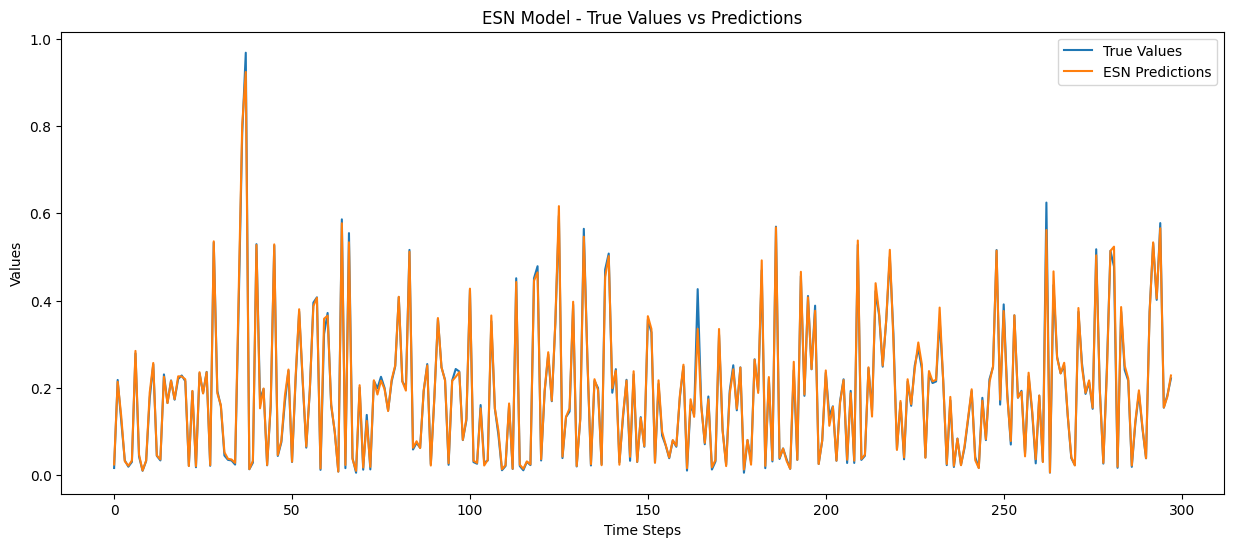

In [ ]:
# Plotting true values vs predictions for ESN
plt.figure(figsize=(15, 6))
plt.plot(y_test, label='True Values')
plt.plot(y_pred_esn, label='ESN Predictions')
plt.title('ESN Model - True Values vs Predictions')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend()
plt.show()


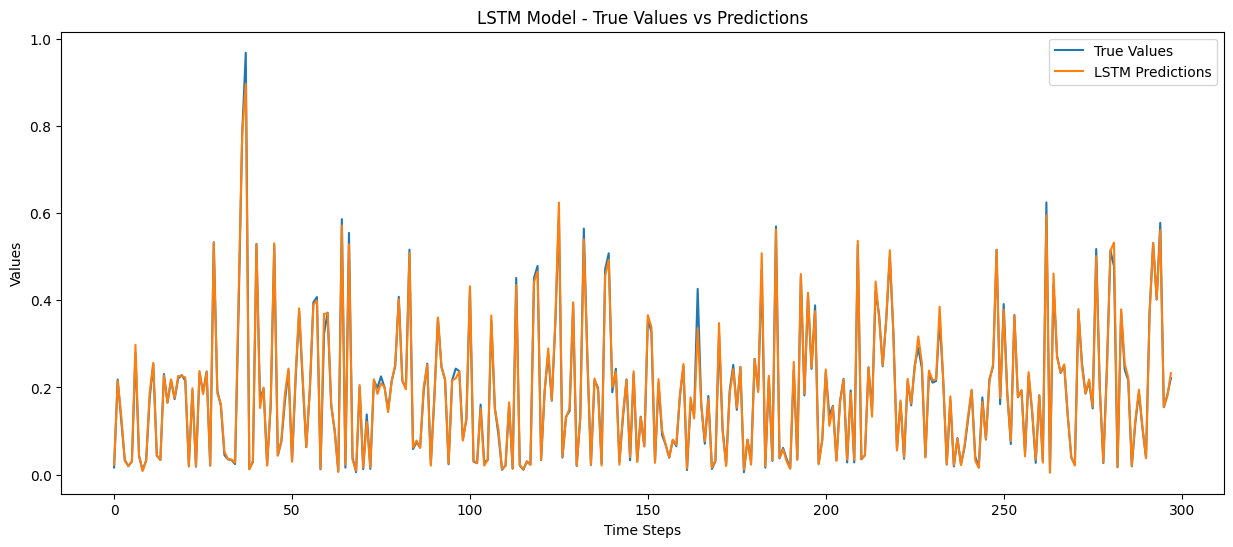

In [ ]:
# Plotting true values vs predictions for LSTM
plt.figure(figsize=(15, 6))
plt.plot(y_test, label='True Values')
plt.plot(y_pred_lstm, label='LSTM Predictions')
plt.title('LSTM Model - True Values vs Predictions')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend()
plt.show()

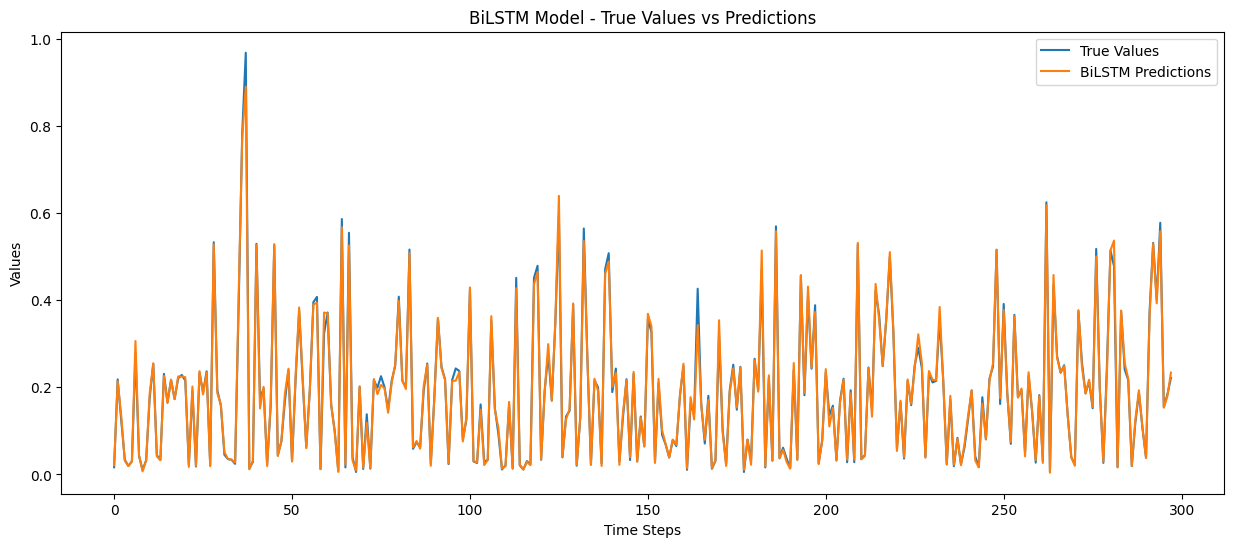

In [ ]:
# Plotting true values vs predictions for BiLSTM
plt.figure(figsize=(15, 6))
plt.plot(y_test, label='True Values')
plt.plot(y_pred_bilstm, label='BiLSTM Predictions')
plt.title('BiLSTM Model - True Values vs Predictions')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend()
plt.show()

In [ ]:
model_esn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 echo_state_reservoir (Echo  (None, None, 50)          2550      
 StateReservoir)                                                 
                                                                 
 dense (Dense)               (None, None, 1)           51        
                                                                 
Total params: 2601 (10.16 KB)
Trainable params: 51 (204.00 Byte)
Non-trainable params: 2550 (9.96 KB)
_________________________________________________________________


In [ ]:
model_lstm.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 50)                10400     
                                                                 
 dense_16 (Dense)            (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model_bilstm.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_5 (Bidirecti  (None, 100)               20800     
 onal)                                                           
                                                                 
 dense_17 (Dense)            (None, 1)                 101       
                                                                 
Total params: 20901 (81.64 KB)
Trainable params: 20901 (81.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Prediction

In [ ]:
# Define the window size and other parameters
window_size = 10
num_days = 50
# Prepare X_pred data
last_window = data['Close'].values[-window_size:]
X_pred = last_window.reshape((1, window_size, 1))


In [ ]:
# Predict using the models for each day
predictions_esn = []
predictions_lstm = []
predictions_bilstm = []

In [ ]:
# Loop to predict values for each day
for _ in range(num_days):
    # Predict using the models
    y_pred_esn = model_esn.predict(X_pred)
    y_pred_lstm = model_lstm.predict(X_pred)
    y_pred_bilstm = model_bilstm.predict(X_pred)

    # Inverse transform the predicted values
    y_pred_esn_inv = scaler.inverse_transform(y_pred_esn.reshape(-1, 1)).flatten()
    y_pred_lstm_inv = scaler.inverse_transform(y_pred_lstm.reshape(-1, 1)).flatten()
    y_pred_bilstm_inv = scaler.inverse_transform(y_pred_bilstm.reshape(-1, 1)).flatten()

    # Min-Max scaling to normalize between 0 and 1
    min_value = data['Close'].min()
    max_value = data['Close'].max()

    y_pred_esn_normalized = (y_pred_esn_inv - min_value) / (max_value - min_value)
    y_pred_lstm_normalized = (y_pred_lstm_inv - min_value) / (max_value - min_value)
    y_pred_bilstm_normalized = (y_pred_bilstm_inv - min_value) / (max_value - min_value)

    # Append the normalized predictions to the lists
    predictions_esn.append(y_pred_esn_normalized[0])
    predictions_lstm.append(y_pred_lstm_normalized[0])
    predictions_bilstm.append(y_pred_bilstm_normalized[0])

    # Update X_pred for the next prediction
    X_pred[0, :-1, 0] = X_pred[0, 1:, 0]  # Shift the values
    X_pred[0, -1, 0] = y_pred_esn[0, 0]

1/1 [==============================] - 0s 21ms/step


In [ ]:
# Min-Max scaling to normalize between 0 and 1
min_value = data['Close'].min()
max_value = data['Close'].max()

# Normalize the predictions
predictions_esn_normalized = (np.array(predictions_esn) - min_value) / (max_value - min_value)
predictions_lstm_normalized = (np.array(predictions_lstm) - min_value) / (max_value - min_value)
predictions_bilstm_normalized = (np.array(predictions_bilstm) - min_value) / (max_value - min_value)

# Print the normalized predictions for each day
for day, (pred_esn, pred_lstm, pred_bilstm) in enumerate(zip(predictions_esn_normalized, predictions_lstm_normalized, predictions_bilstm_normalized), start=1):
    print(f"Day {day} - ESN Prediction (Normalized): {pred_esn}")
    print(f"Day {day} - LSTM Prediction (Normalized): {pred_lstm}")
    print(f"Day {day} - BiLSTM Prediction (Normalized): {pred_bilstm}")
    no_of_day = day

Day 1 - ESN Prediction (Normalized): 474.54638671875
Day 1 - LSTM Prediction (Normalized): 473.0242004394531
Day 1 - BiLSTM Prediction (Normalized): 469.3875732421875
Day 2 - ESN Prediction (Normalized): 474.3207092285156
Day 2 - LSTM Prediction (Normalized): 473.0966796875
Day 2 - BiLSTM Prediction (Normalized): 469.6371765136719
Day 3 - ESN Prediction (Normalized): 474.0478820800781
Day 3 - LSTM Prediction (Normalized): 473.5130310058594
Day 3 - BiLSTM Prediction (Normalized): 470.213134765625
Day 4 - ESN Prediction (Normalized): 473.7788391113281
Day 4 - LSTM Prediction (Normalized): 473.7509460449219
Day 4 - BiLSTM Prediction (Normalized): 470.6922302246094
Day 5 - ESN Prediction (Normalized): 473.5134582519531
Day 5 - LSTM Prediction (Normalized): 473.8393249511719
Day 5 - BiLSTM Prediction (Normalized): 471.073974609375
Day 6 - ESN Prediction (Normalized): 473.2491149902344
Day 6 - LSTM Prediction (Normalized): 473.81414794921875
Day 6 - BiLSTM Prediction (Normalized): 471.373657

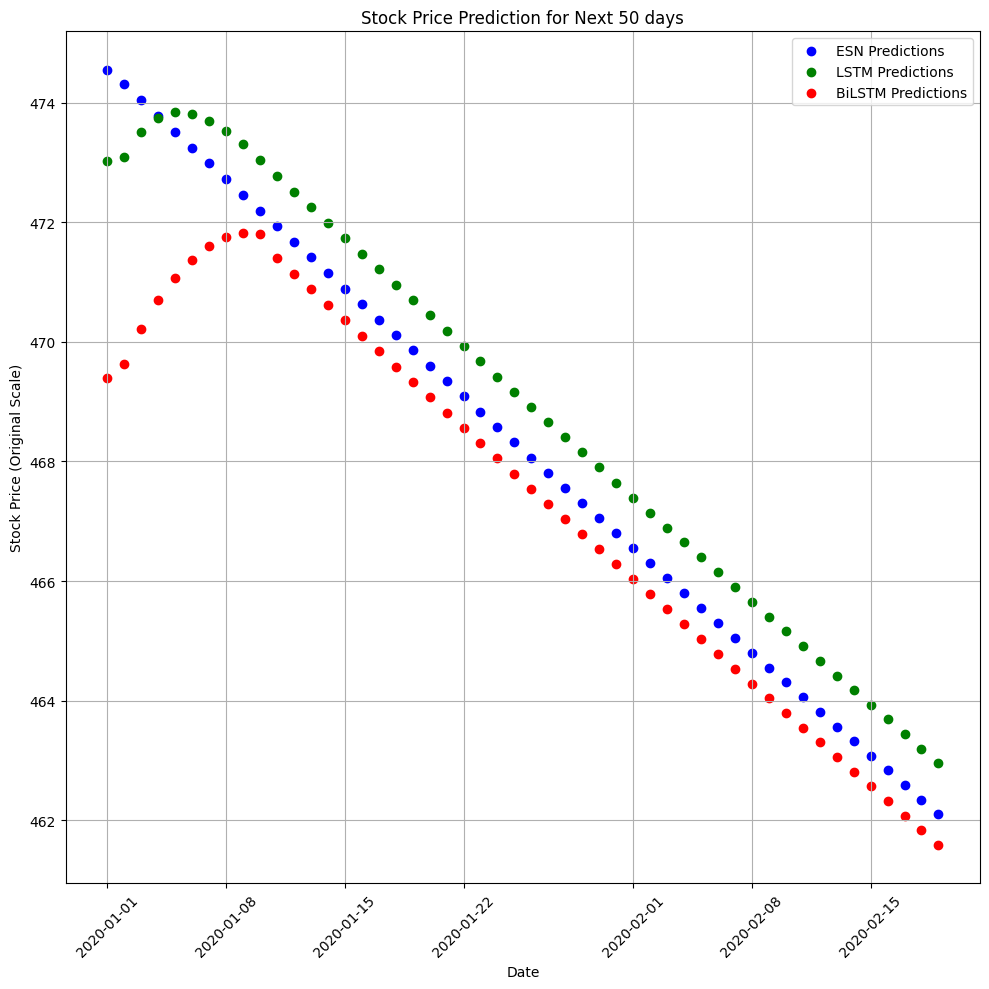

In [ ]:
# Plot the predicted values for each day
plt.figure(figsize=(10, 10))

for day, (pred_esn, pred_lstm, pred_bilstm) in enumerate(zip(predictions_esn, predictions_lstm, predictions_bilstm), start=1):
    plt.scatter(data['Date'].iloc[-1] + pd.to_timedelta(day, unit='D'), pred_esn, label=f'ESN Predictions' if day == 1 else "", marker='o', color='blue')
    plt.scatter(data['Date'].iloc[-1] + pd.to_timedelta(day, unit='D'), pred_lstm, label=f'LSTM Predictions' if day == 1 else "", marker='o', color='green')
    plt.scatter(data['Date'].iloc[-1] + pd.to_timedelta(day, unit='D'), pred_bilstm, label=f'BiLSTM Predictions' if day == 1 else "", marker='o', color='red')

plt.title(f'Stock Price Prediction for Next {day} days')
plt.xlabel('Date')
plt.ylabel('Stock Price (Original Scale)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.tight_layout()  # Adjusts subplot parameters to avoid overlapping
plt.show()

**Based on the models predictions, the stock price is expected to decline. This suggests that the stock will be losing value in the near future**